In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier

# Load Data
bracket_train = pd.read_csv("bracket_training_cleaned.csv")
institutions = pd.read_csv("CCAC 2025 - Institutions_cleaned.csv")


# Features
inst_geo = institutions[[
    "InstitutionID", 
    "InstitutionLatitude", 
    "InstitutionLongitude", 
    "InstitutionDMACode"
]].copy()

inst_perf = institutions[[
    "InstitutionID", 
    "RegularSeasonAverageAttendance", 
    "RegularSeasonAverageScore", 
    "Win_Percentage", 
    "NCAA_Tenure"
]].copy()

inst_scale = institutions[[
    "InstitutionID", 
    "InstitutionEnrollment_Male", 
    "InstitutionEnrollment_Female", 
    "InstitutionEnrollment_Total"
]].copy()


# Merge
regions = ["East", "West", "South", "Midwest"]
for region in regions:
    region_col = f"RegionWinner_{region}"
    inst_temp = inst_geo.copy()
    inst_temp.rename(columns={
        "InstitutionID": region_col,
        "InstitutionLatitude": f"{region}_Inst_Lat",
        "InstitutionLongitude": f"{region}_Inst_Long",
        "InstitutionDMACode": f"{region}_Inst_DMACode"
    }, inplace=True)
    bracket_train = bracket_train.merge(inst_temp, on=region_col, how="left")


regions = ["East", "West", "South", "Midwest"]
for region in regions:
    region_col = f"RegionWinner_{region}"
    inst_temp = inst_perf.copy()
    inst_temp.rename(columns={
    "InstitutionID": region_col,
    "RegularSeasonAverageAttendance": f"{region}_RegularSeasonAverageAttendance",
    "RegularSeasonAverageScore": f"{region}_RegularSeasonAverageScore",
    "Win_Percentage": f"{region}_Win_Percentage",
    "NCAA_Tenure": f"{region}_NCAA_Tenure"
    }, inplace=True)
    bracket_train = bracket_train.merge(inst_temp, on=region_col, how="left")


regions = ["East", "West", "South", "Midwest"]
for region in regions:
    region_col = f"RegionWinner_{region}"
    inst_temp = inst_scale.copy()
    inst_temp.rename(columns={
    "InstitutionID": region_col,
    "InstitutionEnrollment_Male": f"{region}_InstitutionEnrollment_Male",
    "InstitutionEnrollment_Female": f"{region}_InstitutionEnrollment_Female",
    "InstitutionEnrollment_Total": f"{region}_InstitutionEnrollment_Total"
    }, inplace=True)
    bracket_train = bracket_train.merge(inst_temp, on=region_col, how="left", suffixes=(None, f"_{region}"))


# Set Features
base_features = [
    "CustomerID",
    "CustomerDMACode",
    "BracketEntryId",
    "RegionWinner_East",
    "RegionWinner_West",
    "RegionWinner_South",
    "RegionWinner_Midwest",
    "NCAACustomerRecordCreated_Year",
    "NCAACustomerRecordCreated_Month",
    "BracketEntryCreatedDate_Year",
    "BracketEntryCreatedDate_Month"
]

geo_features = []
for region in regions:
    geo_features.extend([f"{region}_Inst_Lat", f"{region}_Inst_Long", f"{region}_Inst_DMACode"])

perf_features = []
for region in regions:
    perf_features.extend([f"{region}_RegularSeasonAverageAttendance", f"{region}_RegularSeasonAverageScore", f"{region}_Win_Percentage", f"{region}_NCAA_Tenure"])

scale_features = []
for region in regions:
    scale_features.extend([f"{region}_InstitutionEnrollment_Male", f"{region}_InstitutionEnrollment_Female", f"{region}_InstitutionEnrollment_Total"])

features = base_features + geo_features + perf_features + scale_features

In [3]:
targets = ["NationalChampion", "SemifinalWinner_East_West", "SemifinalWinner_South_Midwest"]
label_encoders = {}
for target in targets:
    le = LabelEncoder()
    bracket_train[target] = le.fit_transform(bracket_train[target])
    label_encoders[target] = le

bracket_train = bracket_train.fillna(0)

features_to_use = [col for col in features if col not in ["CustomerID", "BracketEntryId"]]

X = bracket_train[features_to_use]
y_nc = bracket_train["NationalChampion"]
y_semi_ew = bracket_train["SemifinalWinner_East_West"]
y_semi_sm = bracket_train["SemifinalWinner_South_Midwest"]

In [5]:
import pickle
from sklearn.ensemble import VotingClassifier

def load_model(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

model_nc_geo = load_model("model_nc_geo.pkl")
model_semi_ew_geo = load_model("model_semi_ew_geo.pkl")
model_semi_sm_geo = load_model("model_semi_sm_geo.pkl")

model_nc_team = load_model("model_nc_team.pkl")
model_semi_ew_team = load_model("model_semi_ew_team.pkl")
model_semi_sm_team = load_model("model_semi_sm_team.pkl")

model_nc_inst = load_model("model_nc_inst.pkl")
model_semi_ew_inst = load_model("model_semi_ew_inst.pkl")
model_semi_sm_inst = load_model("model_semi_sm_inst.pkl")

In [7]:
# Soft Voting
ensemble_nc = VotingClassifier(
    estimators=[
        ('geo', model_nc_geo),
        ('team', model_nc_team),
        ('inst', model_nc_inst)
    ],
    voting='soft'
)

ensemble_semi_ew = VotingClassifier(
    estimators=[
        ('geo', model_semi_ew_geo),
        ('team', model_semi_ew_team),
        ('inst', model_semi_ew_inst)
    ],
    voting='soft'
)

ensemble_semi_sm = VotingClassifier(
    estimators=[
        ('geo', model_semi_sm_geo),
        ('team', model_semi_sm_team),
        ('inst', model_semi_sm_inst)
    ],
    voting='soft'
)

In [9]:
X_train, X_val, y_train_nc, y_val_nc = train_test_split(X, y_nc, test_size=0.2, random_state=42)
_, _, y_train_semi_ew, y_val_semi_ew = train_test_split(X, y_semi_ew, test_size=0.2, random_state=42)
_, _, y_train_semi_sm, y_val_semi_sm = train_test_split(X, y_semi_sm, test_size=0.2, random_state=42)

ensemble_nc.fit(X_train, y_train_nc)
ensemble_semi_ew.fit(X_train, y_train_semi_ew)
ensemble_semi_sm.fit(X_train, y_train_semi_sm)

y_pred_nc = ensemble_nc.predict(X_val)
acc_nc = accuracy_score(y_val_nc, y_pred_nc)
print(f"Accuracy (NationalChampion): {acc_nc:.4f}")

y_pred_semi_ew = ensemble_semi_ew.predict(X_val)
acc_semi_ew = accuracy_score(y_val_semi_ew, y_pred_semi_ew)
print(f"Accuracy (SemiFinal East/West): {acc_semi_ew:.4f}")

y_pred_semi_sm = ensemble_semi_sm.predict(X_val)
acc_semi_sm = accuracy_score(y_val_semi_sm, y_pred_semi_sm)
print(f"Accuracy (SemiFinal South/Midwest): {acc_semi_sm:.4f}")

✅ 앙상블 모델 Accuracy (NationalChampion): 0.4478
✅ 앙상블 모델 Accuracy (SemiFinal East/West): 0.6793
✅ 앙상블 모델 Accuracy (SemiFinal South/Midwest): 0.6249


In [33]:
# Load Test Data
bracket_test = pd.read_csv("bracket_test_cleaned_2.csv")
regions = ["East", "West", "South", "Midwest"]
for region in regions:
    region_col = f"RegionWinner_{region}"
    inst_temp = inst_geo.copy()
    inst_temp.rename(columns={
        "InstitutionID": region_col,
        "InstitutionLatitude": f"{region}_Inst_Lat",
        "InstitutionLongitude": f"{region}_Inst_Long",
        "InstitutionDMACode": f"{region}_Inst_DMACode"
    }, inplace=True)
    bracket_test = bracket_test.merge(inst_temp, on=region_col, how="left")


regions = ["East", "West", "South", "Midwest"]
for region in regions:
    region_col = f"RegionWinner_{region}"
    inst_temp = inst_perf.copy()
    inst_temp.rename(columns={
    "InstitutionID": region_col,
    "RegularSeasonAverageAttendance": f"{region}_RegularSeasonAverageAttendance",
    "RegularSeasonAverageScore": f"{region}_RegularSeasonAverageScore",
    "Win_Percentage": f"{region}_Win_Percentage",
    "NCAA_Tenure": f"{region}_NCAA_Tenure"
    }, inplace=True)
    bracket_test = bracket_test.merge(inst_temp, on=region_col, how="left")


regions = ["East", "West", "South", "Midwest"]
for region in regions:
    region_col = f"RegionWinner_{region}"
    inst_temp = inst_scale.copy()
    inst_temp.rename(columns={
    "InstitutionID": region_col,
    "InstitutionEnrollment_Male": f"{region}_InstitutionEnrollment_Male",
    "InstitutionEnrollment_Female": f"{region}_InstitutionEnrollment_Female",
    "InstitutionEnrollment_Total": f"{region}_InstitutionEnrollment_Total"
    }, inplace=True)
    bracket_test = bracket_test.merge(inst_temp, on=region_col, how="left", suffixes=(None, f"_{region}"))

bracket_test = bracket_test.fillna(0)

X_test_final = bracket_test[features_to_use]

bracket_test["NationalChampion"] = ensemble_nc.predict(X_test_final)
bracket_test["SemifinalWinner_East_West"] = ensemble_semi_ew.predict(X_test_final)
bracket_test["SemifinalWinner_South_Midwest"] = ensemble_semi_sm.predict(X_test_final)

bracket_test["NationalChampion"] = label_encoders["NationalChampion"].inverse_transform(bracket_test["NationalChampion"])
bracket_test["SemifinalWinner_East_West"] = label_encoders["SemifinalWinner_East_West"].inverse_transform(bracket_test["SemifinalWinner_East_West"])
bracket_test["SemifinalWinner_South_Midwest"] = label_encoders["SemifinalWinner_South_Midwest"].inverse_transform(bracket_test["SemifinalWinner_South_Midwest"])

In [35]:
submission = pd.DataFrame()
submission["BracketEntryId"] = bracket_test["BracketEntryId"]
submission["SemifinalWinner_East_West"] = bracket_test["SemifinalWinner_East_West"]
submission["SemifinalWinner_South_Midwest"] = bracket_test["SemifinalWinner_South_Midwest"]
submission["NationalChampion"] = bracket_test["NationalChampion"]

submission.to_csv("submission_ensemble.csv", index=False)
print("Submission file saved as submission_ensemble.csv")

Submission file saved as submission_ensemble.csv


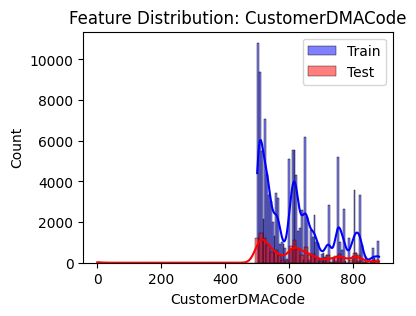

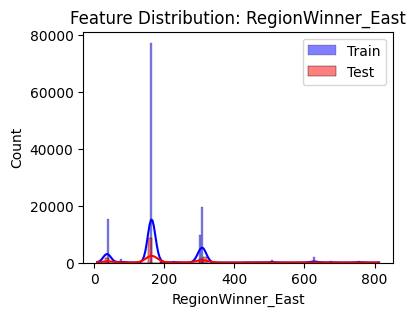

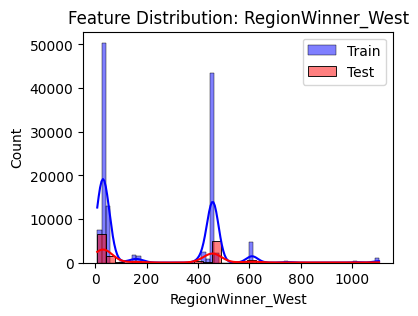

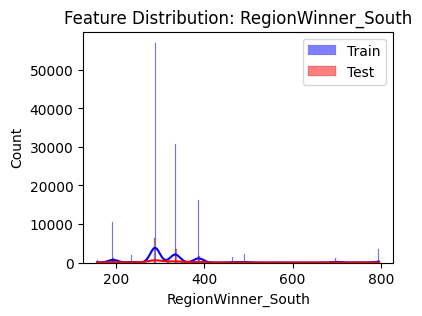

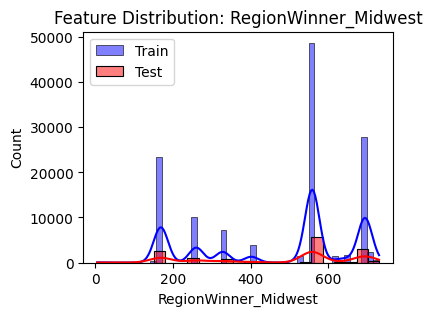

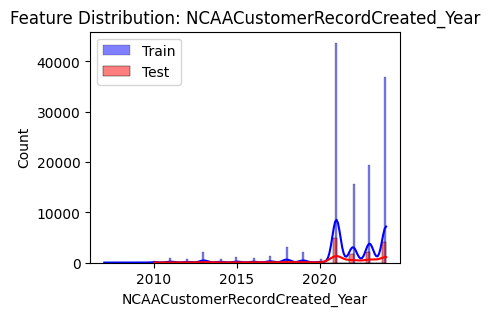

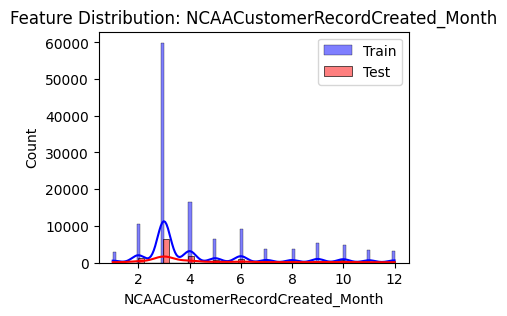

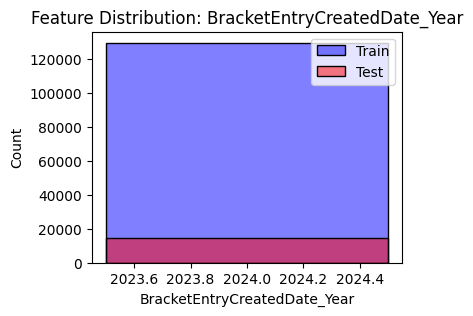

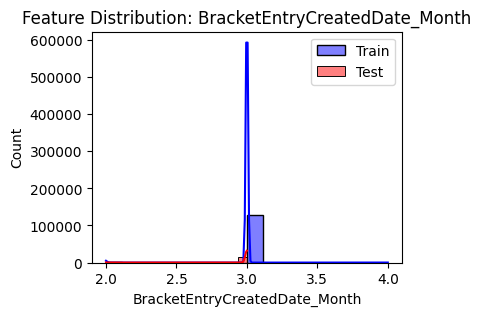

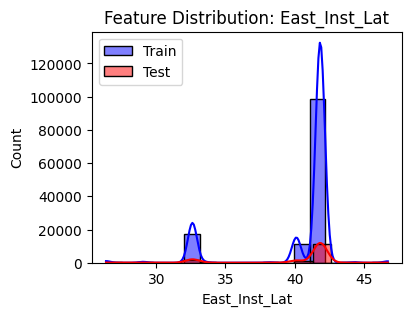

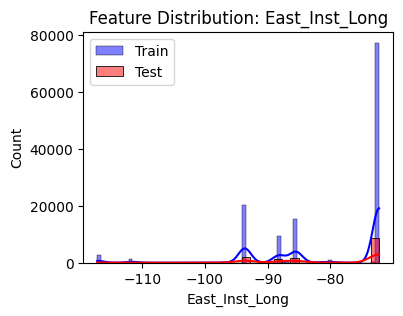

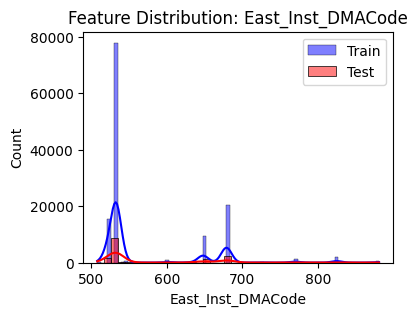

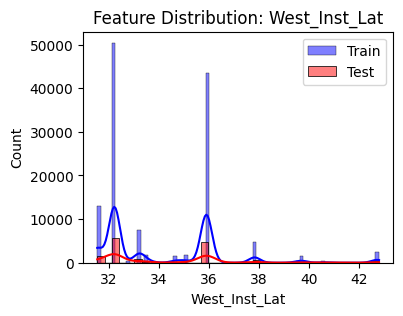

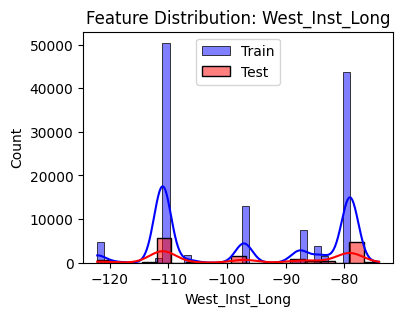

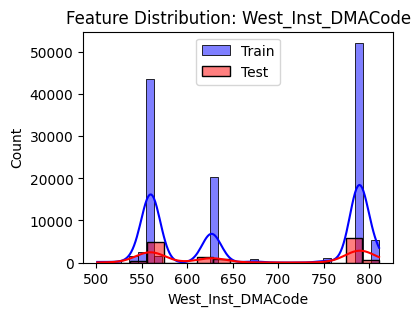

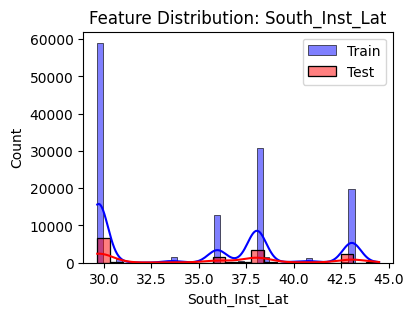

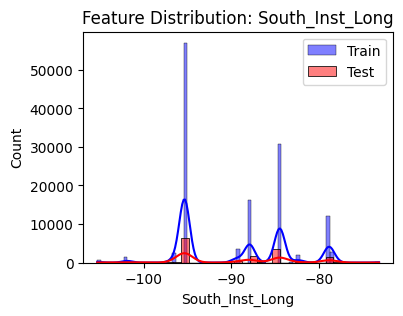

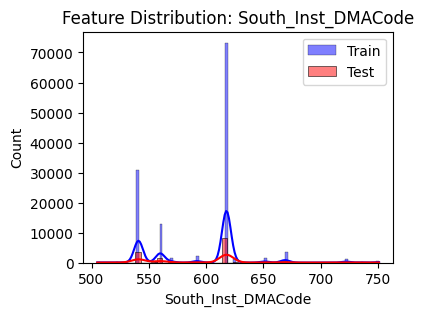

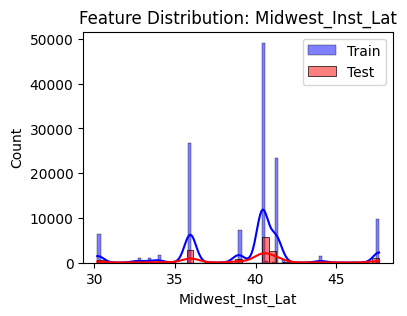

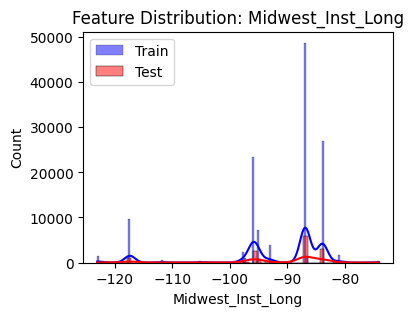

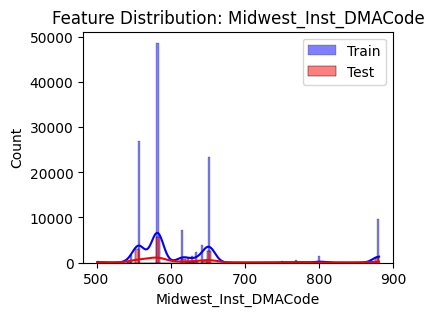

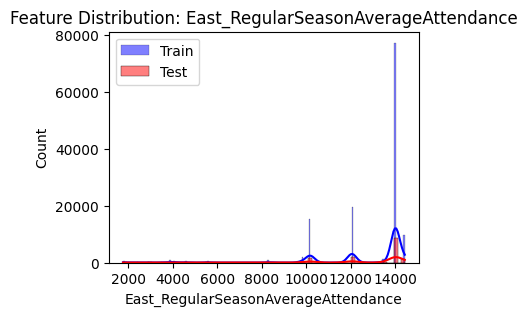

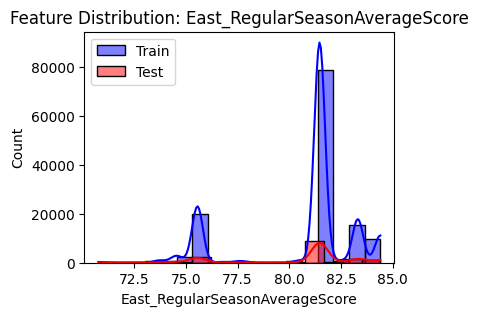

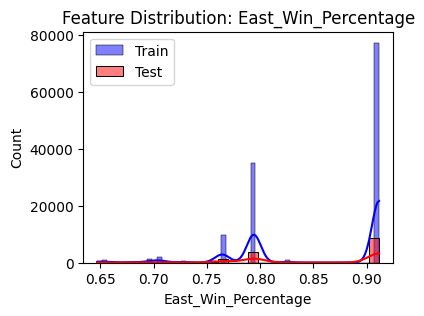

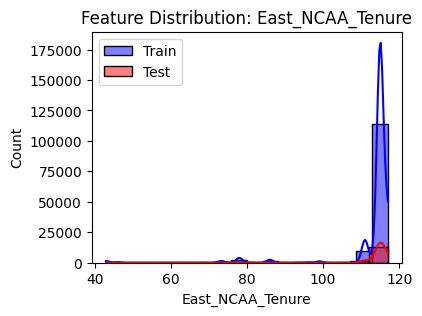

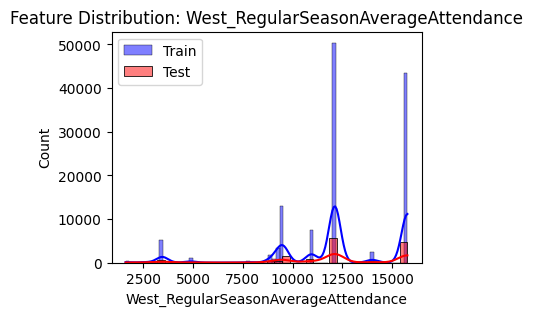

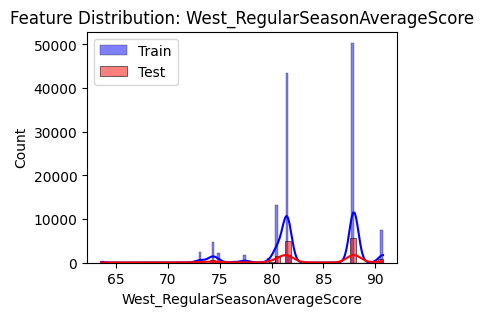

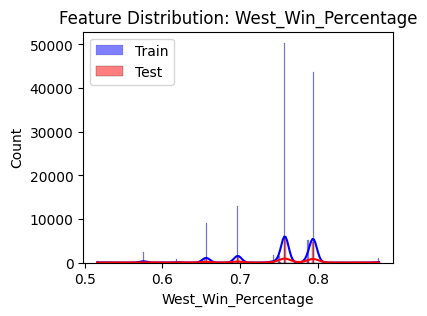

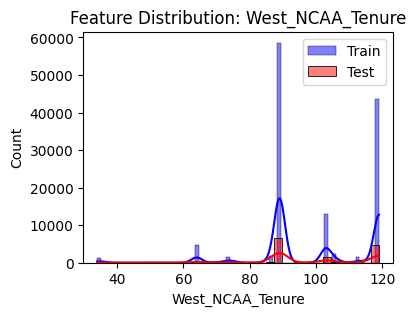

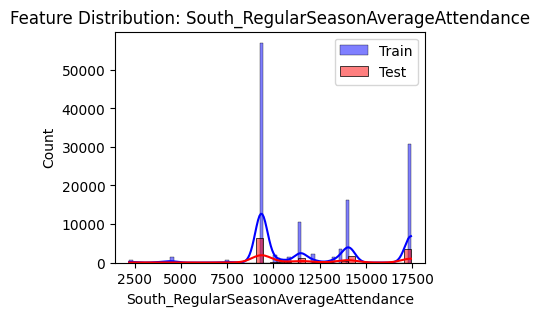

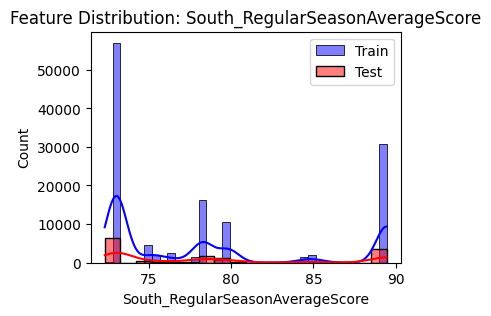

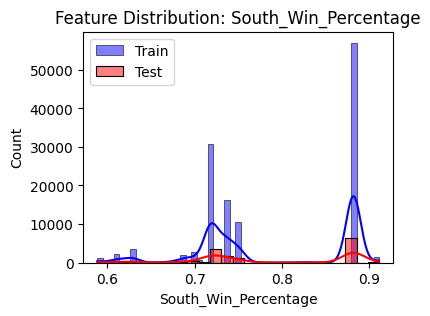

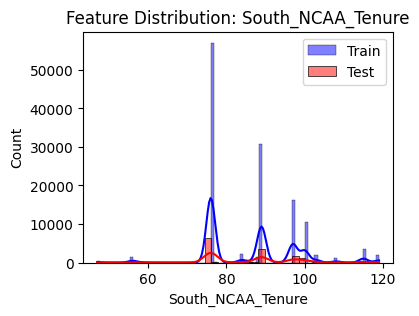

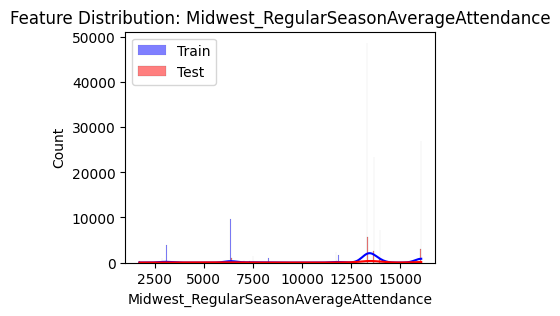

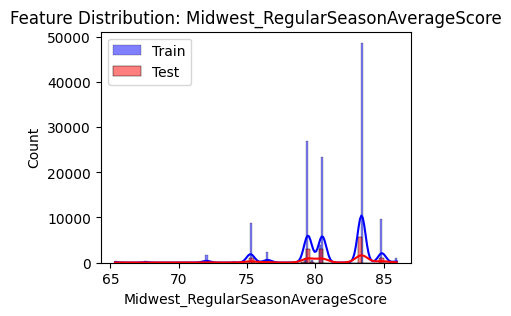

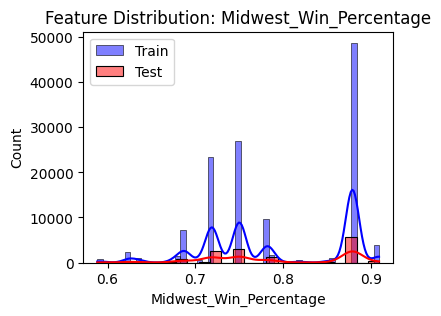

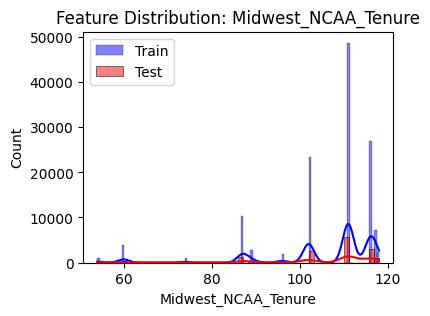

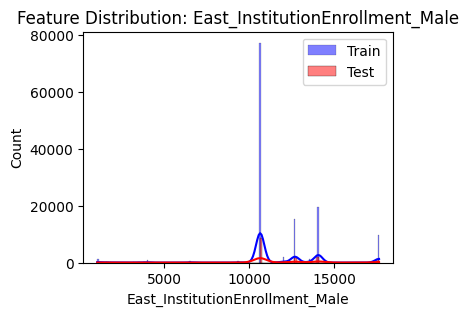

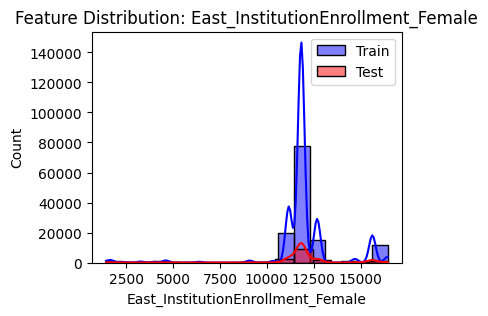

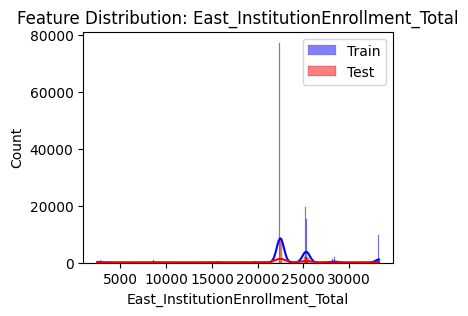

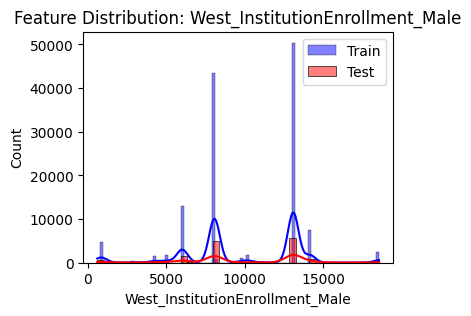

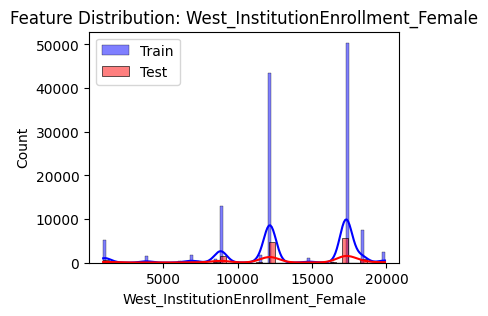

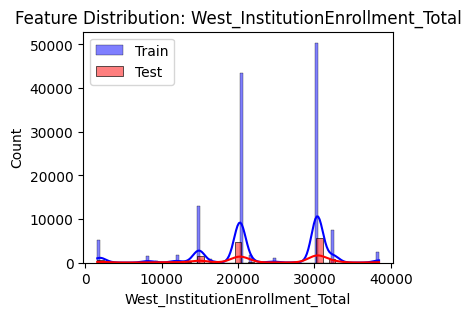

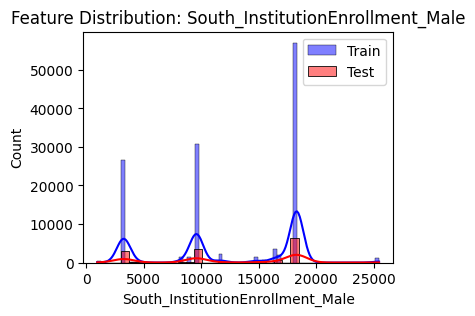

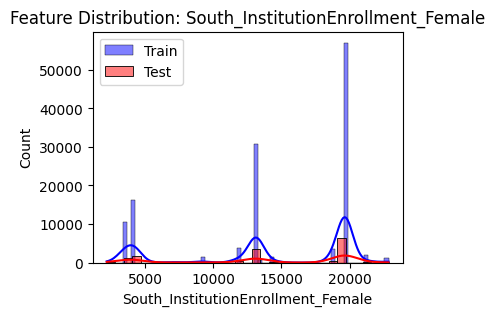

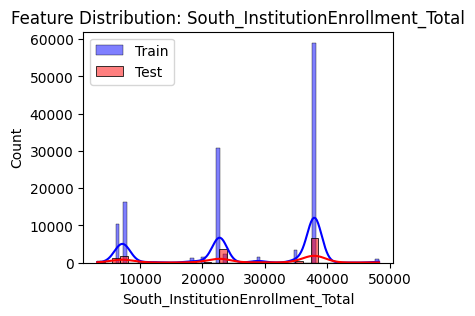

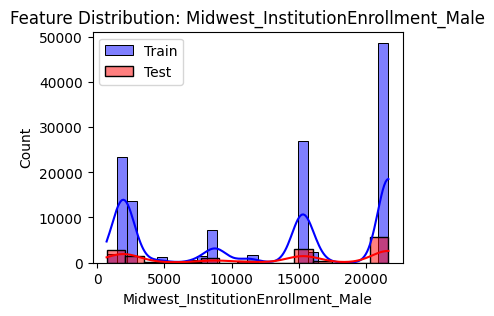

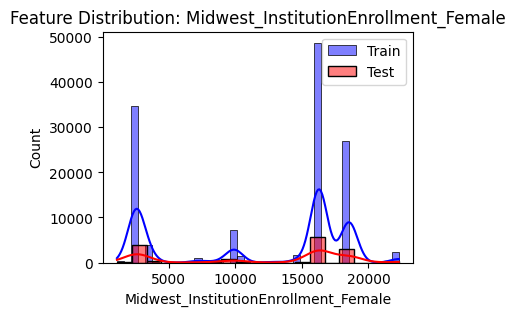

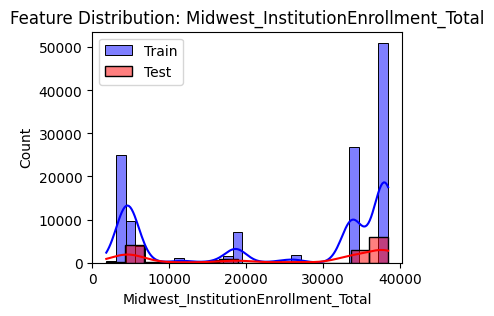

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compare Each Feature Distribution
for feature in features_to_use:
    plt.figure(figsize=(4, 3))
    sns.histplot(bracket_train[feature], label="Train", kde=True, color="blue")
    sns.histplot(bracket_test[feature], label="Test", kde=True, color="red")
    plt.legend()
    plt.title(f"Feature Distribution: {feature}")
    plt.show()